# Plot trends in OLR, ASR, and AIRS spectral OLR by month

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CERES-EBAF data

In [2]:
ceres_dir = '/glade/work/jonahshaw/obs/CERES'
ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [3]:
ceres_ds = xr.open_dataset('%s/%s' % (ceres_dir,ceres_file))

#### Add an absorbed solar radiation variable

In [4]:
ceres_ds['ASR'] = ceres_ds['solar_mon'] - ceres_ds['toa_sw_all_mon']

In [74]:
temp_alb = (ceres_ds['toa_sw_all_mon'] / ceres_ds['solar_mon'])
# weird 2-step process required??
ceres_ds['albedo'] = temp_alb.where(ceres_ds['solar_mon'] > 15) #.where(temp_alb > 15,np.nan) # poorly defined when insolation is less than 15 W/m^2

### Plot month OLRs for the Arctic Ocean (70-90N)

If I want to use a better mask, should I use the LANDFRAC variable in CESM or is there something better?

In [6]:
olr_wgt = add_weights(ceres_ds['toa_lw_all_mon'])

In [7]:
month_groups = olr_wgt.groupby('time.month')

Compute monthly OLRs (inefficient, could vectorize)

In [8]:
olr_temp = []
labels = []

for label,month in month_groups:
    arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat<70)
    
    olr_temp.append(arc_ocn_avg)
    labels.append(label)
#     break
olr_temp = np.array(olr_temp)

#### Sanity plot looks good

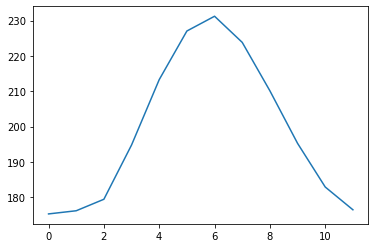

In [9]:
plt.plot(olr_temp)

### Plot a monthly trend

In [10]:
# average over the Arctic Ocean spatially, but not temporally
spat_avg = masked_average(olr_wgt,weights=olr_wgt['cell_weight'],mask=olr_wgt.lat<70,dim=['lat','lon'])

#### All months sanity plot looks good

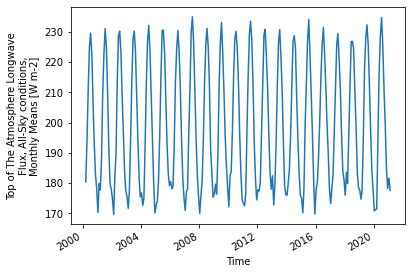

In [11]:
spat_avg.plot()

In [12]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

Text(0.5, 0.98, 'CERES OLR (70-90N)')

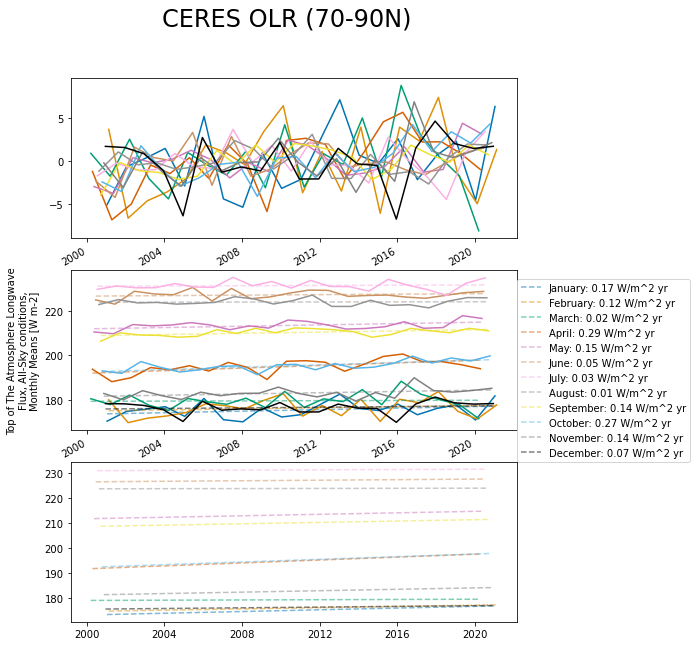

In [13]:
fig,axes = plt.subplots(3,1,figsize=(8,10))

lines=[]
mon_groups = spat_avg.groupby('time.month')

for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
    mon_norm = mon - mon.mean() # normalize to the average

    out = regress_1d(mon['time.year'],mon)
    line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
    label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)
    
    
    mon_norm.plot(label=label,ax=axes[0],color=color)
    out = mon.plot(label=label,ax=axes[1],color=color)
    
    axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
    axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)    
    
    lines.append(out)
    
axes[2].legend(loc=[1,1])

fig.suptitle('CERES OLR (70-90N)',fontsize=24)

### Package and repeat for other CERES variables

In [172]:
def plot_trends(ds,title,units='W/m^2'):
    '''
    Create the above plot with a single command.
    
    '''
    
    var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
    try:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    except:
        spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.latitude<70,dim=['latitude','longitude'])
        
    fig,axes = plt.subplots(3,1,figsize=(8,10))

    lines=[]
    mon_groups = spat_avg.groupby('time.month')

    for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
        mon_norm = mon - mon.mean() # normalize to the average

        if True in np.isnan(mon):
            print('nan in monthly averages for %s' % mon_dict[str(ind)])
#             print(mon.values)
        else:
            out = regress_1d(mon['time.year'],mon)
            
            line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
            label = '%s: %.2f %s /yr' % (mon_dict[str(ind)],out.coef_,units)


            mon_norm.plot(label=label,ax=axes[0],color=color)
            out = mon.plot(label=label,ax=axes[1],color=color)

            axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
            axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)

            lines.append(out)

    axes[2].legend(loc=[1,1])

    fig.suptitle(title,fontsize=24)
    

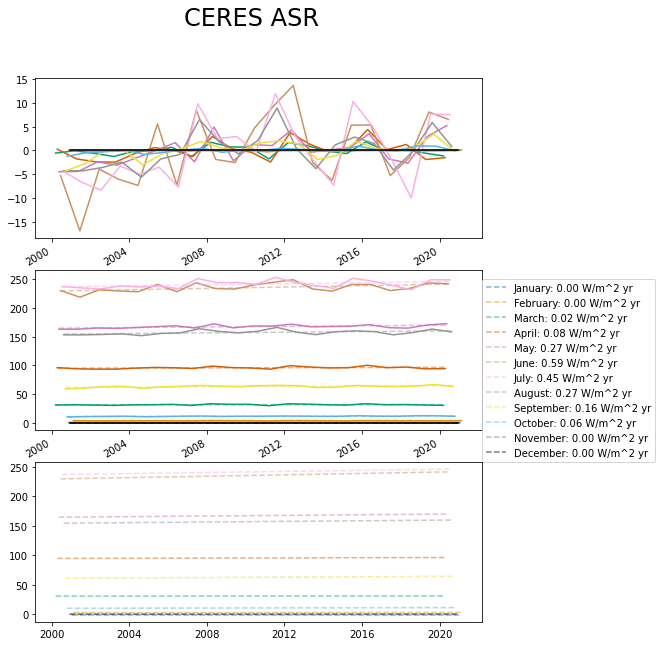

In [77]:
plot_trends(ceres_ds['ASR'],'CERES ASR')

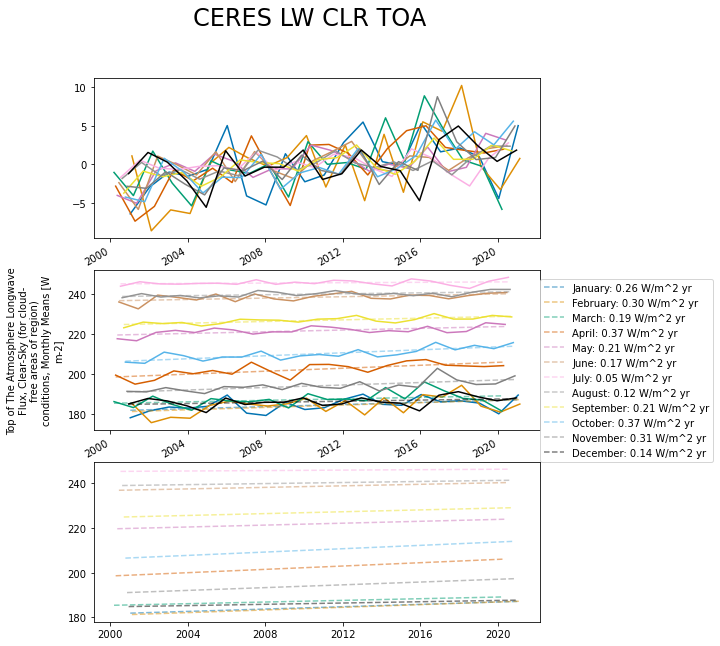

In [16]:
plot_trends(ceres_ds['toa_lw_clr_c_mon'],'CERES LW CLR TOA')

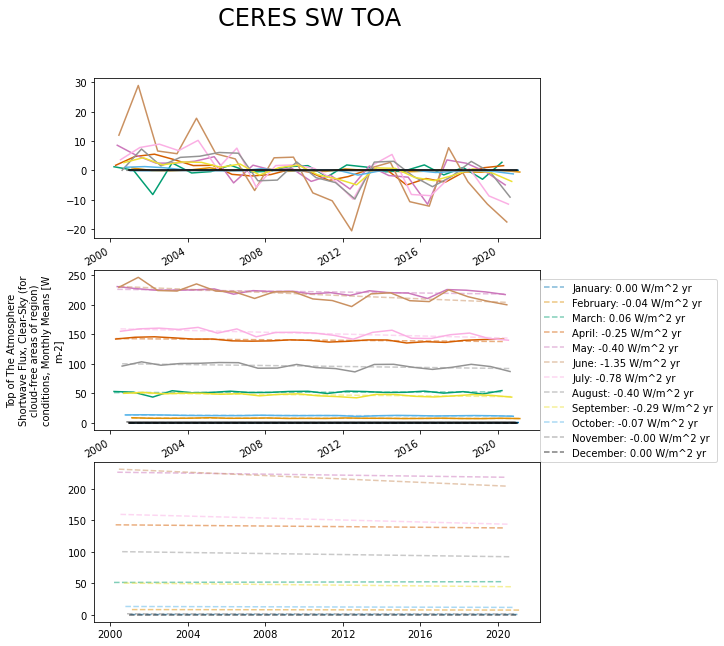

In [47]:
plot_trends(ceres_ds['toa_sw_clr_c_mon'],'CERES outgoing SW TOA')

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


nan in monthly averages for January
nan in monthly averages for November
nan in monthly averages for December


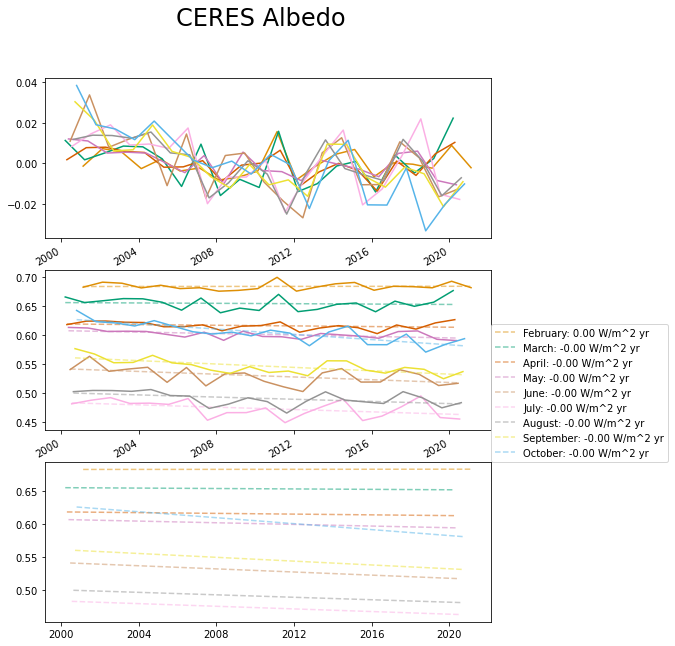

In [85]:
error = plot_trends(ceres_ds['albedo'],'CERES Albedo')

## Plot trends in surface temperature from the NASA GISS dataset

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [86]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [88]:
ls $gisstemp_path

air.2x2.1200.mon.anom.comb.nc        GISTEMP_timeseries.nc
air.2x2.1200.mon.anom.comb.nc.v2019  readme.txt


In [94]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here
# giss2 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc.v2019'))

In [97]:
ceres_time = ceres_ds.time

In [102]:
ceres_time.values[-1]

numpy.datetime64('2021-02-15T00:00:00.000000000')

In [111]:
giss_tsel = giss1.sel(time=slice('2000-03','2021-03'))

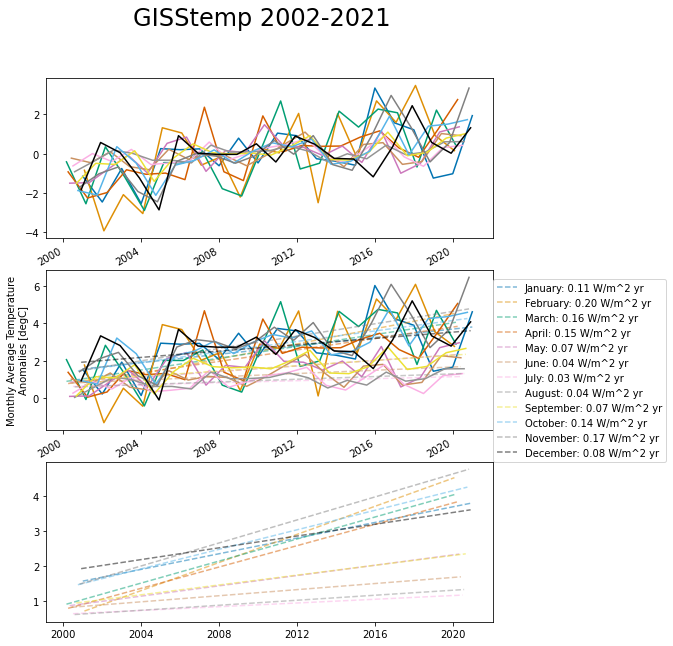

In [116]:
plot_trends(giss_tsel['air'],'GISStemp 2002-2021')

## GOCCP liquid cloud amount

In [117]:
goccp_dir = '/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/grid_2x2_L40/'

In [119]:
# identifying strings
phase_str = 'Phase330m'
height_str = 'High330m'

In [154]:
height_files = glob.glob('%s/*/*%s*.nc' % (goccp_dir,height_str))
height_files.sort()

phase_files = glob.glob('%s/*/*%s*.nc' % (goccp_dir,phase_str))
phase_files.sort()

In [151]:
xr.open_dataset(phase_files[-2])

<xarray.Dataset>
Dimensions:          (cat1: 6, latitude: 90, longitude: 180, time: 1, toplvl: 3)
Coordinates:
  * time             (time) datetime64[ns] 2020-11-15
  * latitude         (latitude) float32 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * longitude        (longitude) float32 -179.0 -177.0 -175.0 ... 177.0 179.0
  * toplvl           (toplvl) float32 0.0 0.0 0.0
Dimensions without coordinates: cat1
Data variables:
    category         (cat1) |S25 ...
    clhcalipso_RPIC  (time, latitude, longitude) float32 ...
    clhcalipso_ice   (time, latitude, longitude) float32 ...
    clhcalipso_liq   (time, latitude, longitude) float32 ...
    clhcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cllcalipso_RPIC  (time, latitude, longitude) float32 ...
    cllcalipso_ice   (time, latitude, longitude) float32 ...
    cllcalipso_liq   (time, latitude, longitude) float32 ...
    cllcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clmcalipso_RPIC  (time, latitude, longitude) float32 ...
    clmcalipso_ice   (time, latitude, longitude) float32 ...
    clmcalipso_liq   (time, latitude, longitude) float32 ...
    clmcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cltcalipso_RPIC  (time, latitude, longitude) float32 ...
    cltcalipso_ice   (time, latitude, longitude) float32 ...
    cltcalipso_liq   (time, latitude, longitude) float32 ...
    cltcalipso_un    (time, cat1, latitude, longitude) float32 ...
Attributes:
    Description:         GOCCP_Map_Low_Mid_High_Phase_file
    Date:                
    Version:             Prog_version
    Author:              Gregory CESANA, Helene CHEPFER, LMD/IPSL
    Scientific_contact:  helene.chepfer@lmd.polytechnique.fr
    Technical_support:   gregory.cesana@lmd.polytechnique.fr
    Creationdate:        20210421
    Website:             http://climserv.ipsl.polytechnique.fr/cfmip-obs.html
    References:          Chepfer et al, 2010, The GCM Oriented CALIPSO Cloud ...
    history:             Fri May  7 11:41:22 2021: ncra -O /bdd/CFMIP/CFMIP_O...
    NCO:                 netCDF Operators version 4.7.9 (Homepage = http://nc...

In [155]:
goccp_phase = xr.open_mfdataset(phase_files)

goccp_height = xr.open_mfdataset(height_files)

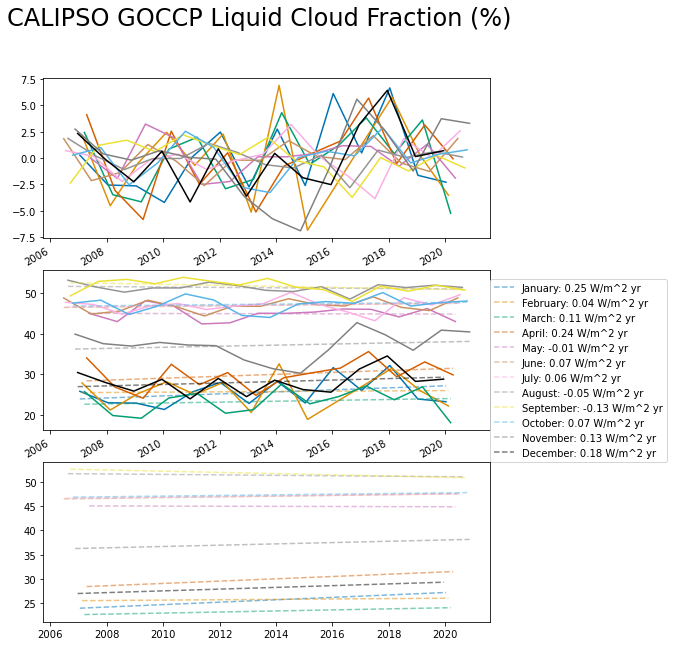

In [164]:
plot_trends(100*goccp_phase['cltcalipso_liq'],'CALIPSO GOCCP Liquid Cloud Fraction (%)')

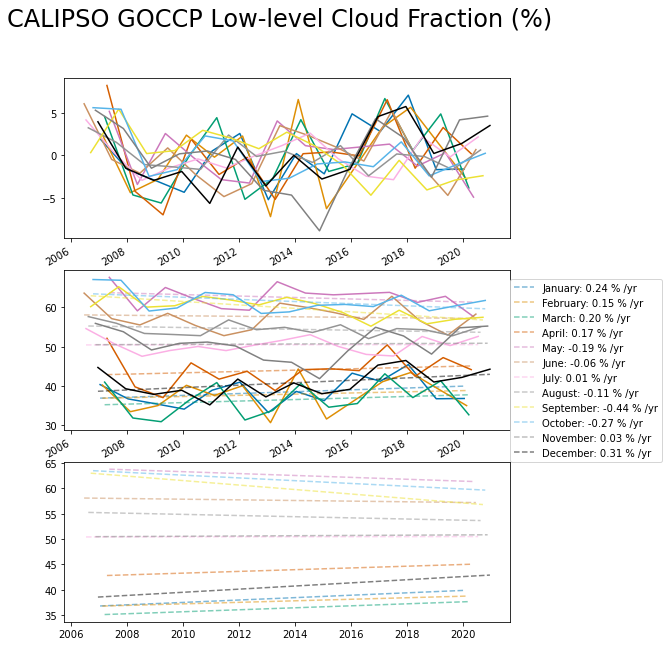

In [173]:
plot_trends(100*goccp_height['cllcalipso'],'CALIPSO GOCCP Low-level Cloud Fraction (%)',units='%')

In [57]:
arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat>70)

In [58]:
arc_ocn_avg

<xarray.DataArray ()>
array(239.40678, dtype=float32)
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

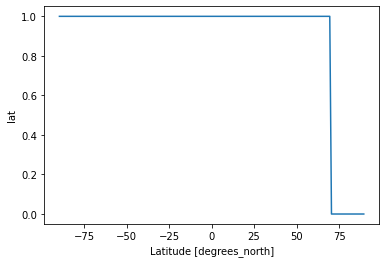

In [55]:
(month.lat<70).plot()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


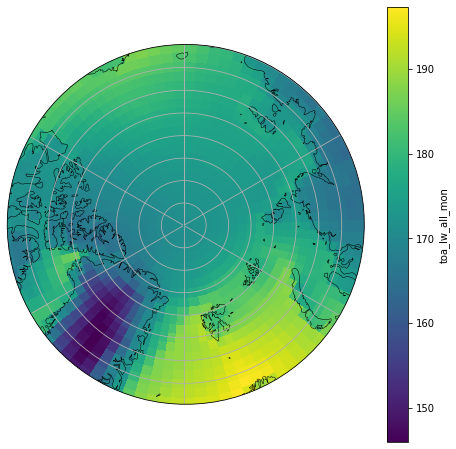

In [43]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

month.where(month.lat>70).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

add_map_features(ax)

In [21]:
type(group)

xarray.core.dataarray.DataArray

In [33]:
ax.plot(month.where(month.lat>70).mean('time'),projection=ccrs.NorthPolarStereo())

AttributeError: 'Line2D' object has no property 'projection'

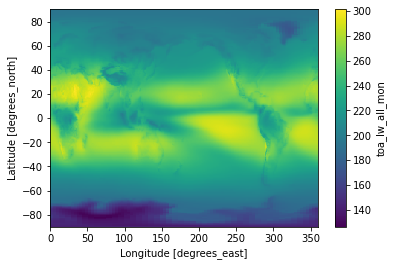

In [9]:
ceres_ds['toa_lw_all_mon'].mean('time').plot()

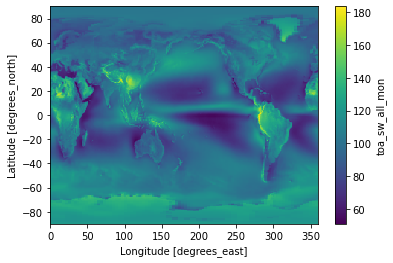

In [10]:
ceres_ds['toa_sw_all_mon'].mean('time').plot()

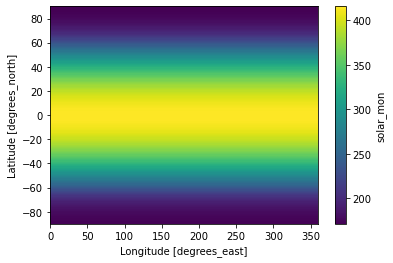

In [11]:
ceres_ds['solar_mon'].mean('time').plot()

In [ ]:
OSR=ds.toa_sw_all_mon.mean('time') ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon.mean('time')    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation